# Simon's Problem
Jeries Dababneh and Esteban Duran

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sympy import *
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

import warnings
warnings.simplefilter('ignore')

In [2]:
def simons_circuit(qbits, secret):
    n = qbits

    qr = QuantumRegister(n*2) # 4 qubit register
    cr = ClassicalRegister(n) # 1 classical register
    circ = QuantumCircuit(qr, cr) # Quantum Circuit on q

    for i in range(0, n):
        circ.h(qr[i])

    circ.barrier()

    for i in range(0, n):
        circ.cx(qr[i], qr[n+i])
    circ.barrier()

    s = secret

    #xor s.
    for i, c in enumerate(s):
        if c == '0':
            circ.cx(qr[i], qr[n+i])

    circ.barrier()

    for i in range(0, n):
        circ.h(qr[i])
        circ.measure(qr[i], cr[i])
    return circ

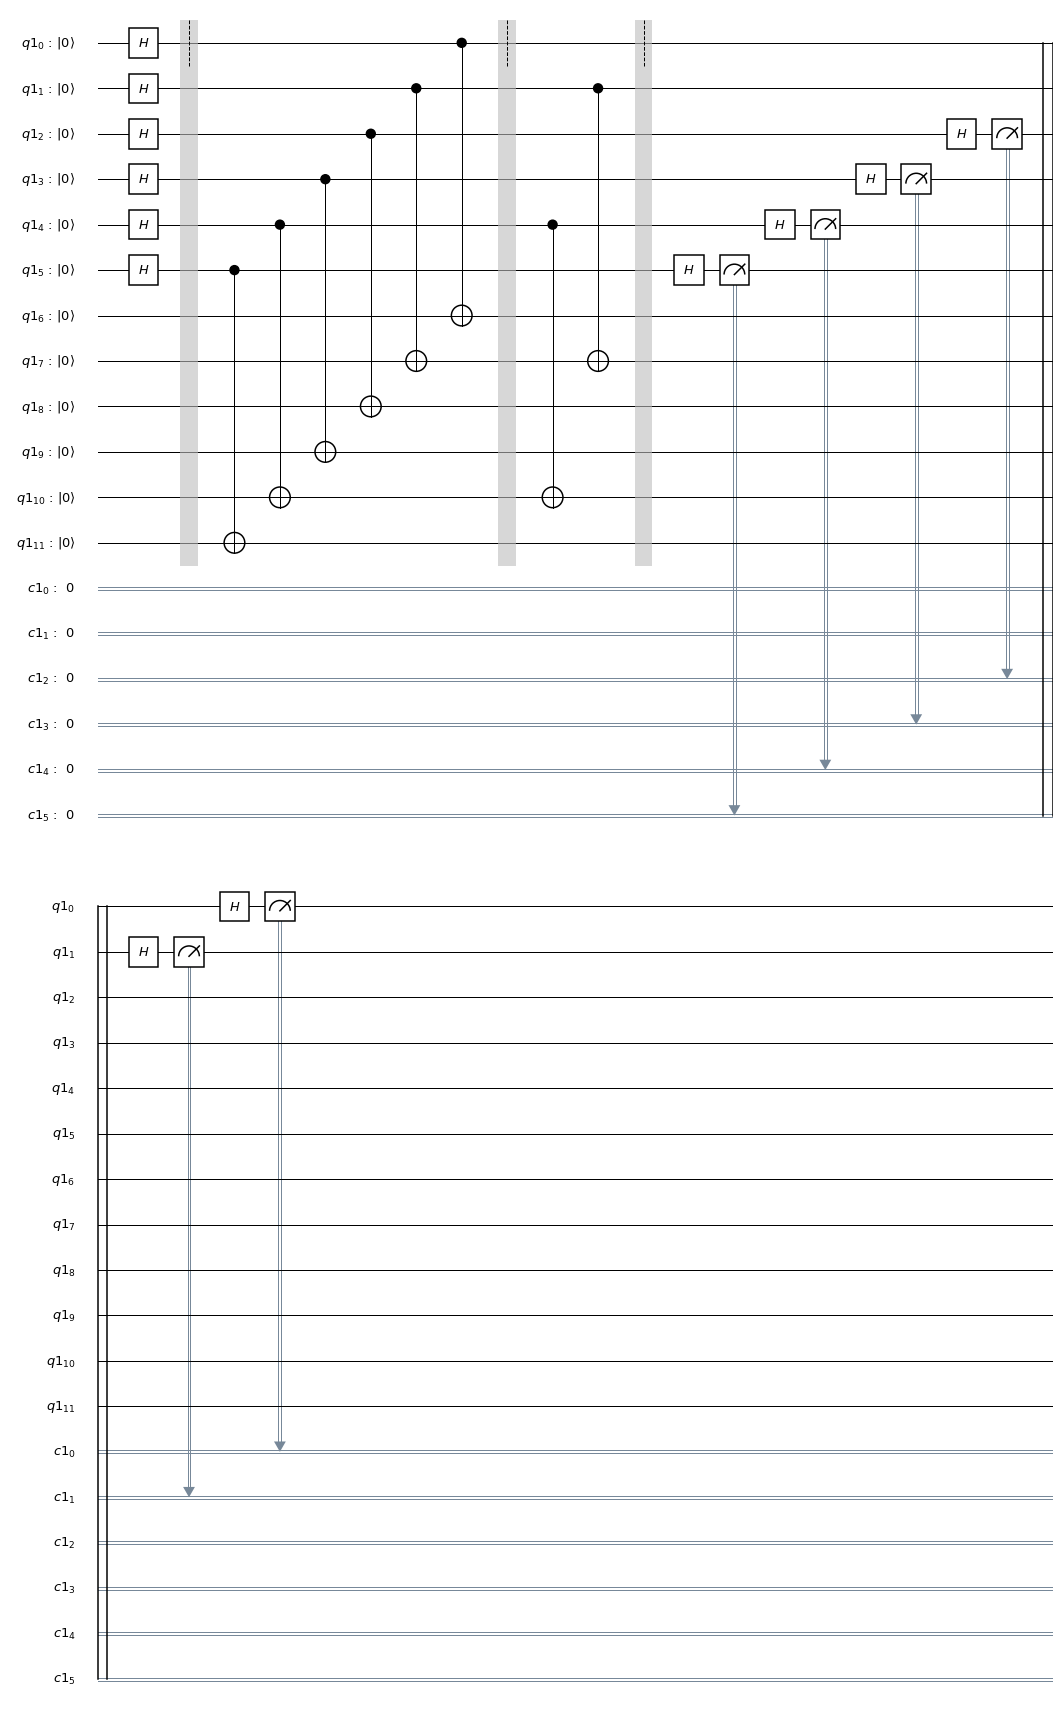

In [15]:
n = 6
secret = '101101'
circ = simons_circuit(n, secret)
circ.draw(output='mpl')

In [5]:
# turn the measured string into an array of integers.
def get_wi(w):
    v = []
    for i in range(n):
        v.append(int(w[(n-i) - 1]))
    return v

In [20]:
simulator = Aer.get_backend('qasm_simulator')

#get first measurement to start making the matrix ofr the system of equations.
result = execute(circ, simulator, shots=1).result()
temp = result.get_counts(circ)
mes = next(iter(temp))
count = {}
count[mes] = 1
wi = get_wi(mes)
M = Matrix([wi])

#while loop to collect the rest
dim = 1
i = 0
while(True and i < 100 ):
    #run simul, get measurement
    result = execute(circ, simulator, shots=1).result()
    temp = result.get_counts(circ)
    mes = next(iter(temp))
    wi = get_wi(mes)
    if mes in count:
        count[mes] = count[mes] + 1
    # make augment matrix by adding the new row
    ma = M.col_join(Matrix([wi]))
    
    #check if new measuremnt is in the span of {w_i}
    m, mr = M.rref()
    mA, mar = ma.rref()
    if mr != mar:
        count[mes] = 1
        M = ma
        dim = dim + 1
    elif (dim == n - 1):
        break
    i = i + 1
M, _ = M.rref()
#ptrint the system of equations that satisfy s
rows, cols = M.shape
for r in range(rows):
    Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(M[r,:])) if v == 1 ]
    if len(Yr) > 0:
        tStr = " + ".join(Yr)
        print(tStr, "= 1")
M

s[ 0 ] = 1
s[ 2 ] = 1
s[ 3 ] = 1
s[ 5 ] = 1


Matrix([
[1, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0],
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 1]])

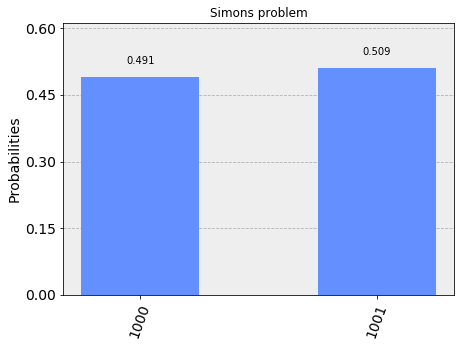

In [9]:
plot_histogram(count, title='Simons problem')